In [1]:
# Importing necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Importing TensorFlow and Keras modules
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import *  # Importing pretrained models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Suppressing warnings
import warnings 
warnings.filterwarnings("ignore")

2024-03-12 11:33:21.213057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 11:33:21.213170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 11:33:21.358909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Directory containing the "Train" folder
directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"

# Lists to store file paths and labels
file_paths = []
labels = []

# Iterate over subfolders in the directory
for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    
    # Iterate over images in the subfolder
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image)
        file_paths.append(image_path)
        labels.append(folder)

# Create Pandas Series for file paths and labels
file_path_series = pd.Series(file_paths, name='filepath')
label_series = pd.Series(labels, name='label')

# Concatenate file paths and labels into a DataFrame
df_train = pd.concat([file_path_series, label_series], axis=1)

In [3]:
# Displaying the first few rows of the DataFrame
print(df_train.head())

                                            filepath      label
0  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
1  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
2  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
3  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
4  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA


In [4]:
import os
import pandas as pd

# Directory containing the "Test" folder
directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

# Lists to store file paths and corresponding labels
file_paths = []
labels = []

# Iterate through each folder in the directory
for label_folder in os.listdir(directory):
    folder_path = os.path.join(directory, label_folder)
    
    # Iterate through each image in the folder
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        file_paths.append(image_path)
        labels.append(label_folder)

# Create DataFrame to store file paths and labels
df_test = pd.DataFrame({'file_path': file_paths, 'label': labels})

# Display a random sample of 5 rows from the DataFrame
print(df_test.sample(10))

                                             file_path      label
340  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
150  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
292  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
120  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
306  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
38   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
245  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
362  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
522  /kaggle/input/chest-xray-pneumonia/chest_xray/...     NORMAL
59   /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA


In [5]:
# Print the shape of the training and test data
print(f"The shape of the training data is: {df_train.shape}")
print(f"The shape of the test data is: {df_test.shape}")

The shape of the training data is: (5216, 2)
The shape of the test data is: (624, 2)


In [6]:
# Define the directory paths
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

# Define the image size
IMAGE_SIZE = (256, 256)

# Load and preprocess training data
print('Training Images:')
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32,
    shuffle=True)

# Load and preprocess validation data
print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32,
    shuffle=True)

# Load and preprocess test data
print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32,
    shuffle=False)  # No need to shuffle test data

Training Images:
Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Validation Images:
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Testing Images:
Found 624 files belonging to 2 classes.


In [7]:
# Extract labels from the datasets
train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names

# Define your class labels
class_labels = ['NORMAL', 'PNEUMONIA'] 

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the class labels
label_encoder.fit(class_labels)

# Transform the labels for training dataset
train_labels_encoded = label_encoder.transform(train_labels)

# Transform the labels for validation dataset
validation_labels_encoded = label_encoder.transform(validation_labels)

# Transform the labels for test dataset
test_labels_encoded = label_encoder.transform(test_labels)

# Print the encoded labels
print("Encoded Training Labels:", train_labels_encoded)
print("Encoded Validation Labels:", validation_labels_encoded)
print("Encoded Test Labels:", test_labels_encoded)

Encoded Training Labels: [0 1]
Encoded Validation Labels: [0 1]
Encoded Test Labels: [0 1]


In [8]:
# Iterate over the training dataset to print the shape of the data batches
for image_batch, labels_batch in train_ds:
    print("Shape of X_train: ", image_batch.shape)  # Shape of the input images
    print("Shape of y_train: ", labels_batch.shape)  # Shape of the corresponding labels
    break  # Break after printing the shape of the first batch

Shape of X_train:  (32, 256, 256, 3)
Shape of y_train:  (32,)


In [9]:
# Normalize pixel values in the training dataset
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))

# Normalize pixel values in the validation dataset
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))

# Normalize pixel values in the test dataset
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

In [10]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path)
    
    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))
    
    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')
    
    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Construct the full image path
        image_path = os.path.join(path, image_filename)
        
        # Load the image using Matplotlib
        image = mpimg.imread(image_path)
        
        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

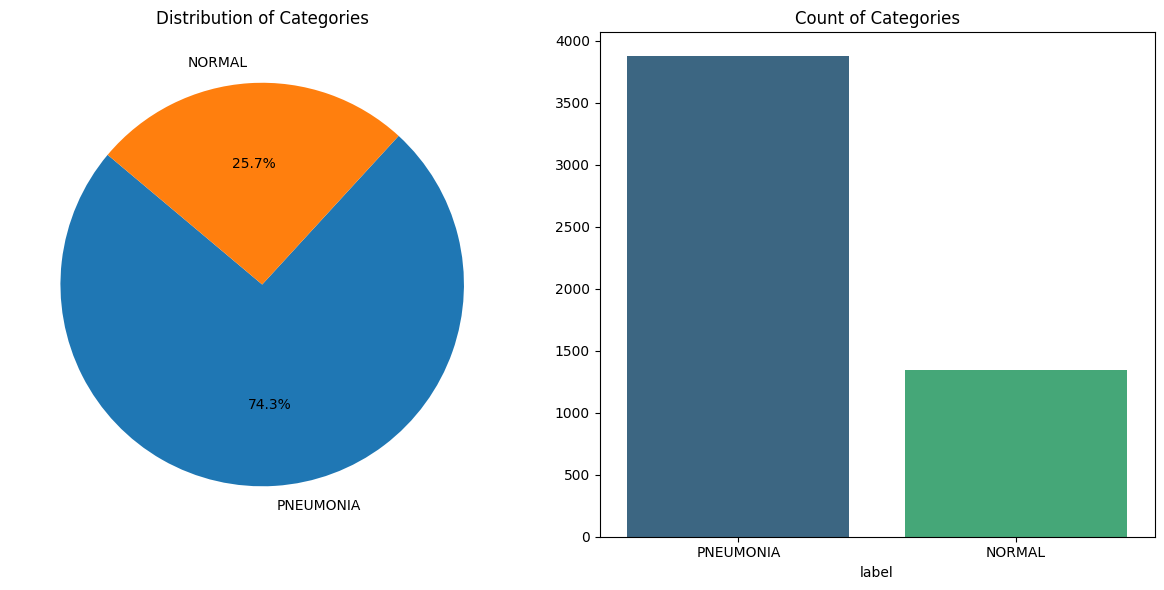

In [11]:
# Count the occurrences of each category in the 'label' column
count = df_train['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path)
    
    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))
    
    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')
    
    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Construct the full image path
        image_path = os.path.join(path, image_filename)
        
        # Load the image using Matplotlib
        image = mpimg.imread(image_path)
        
        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

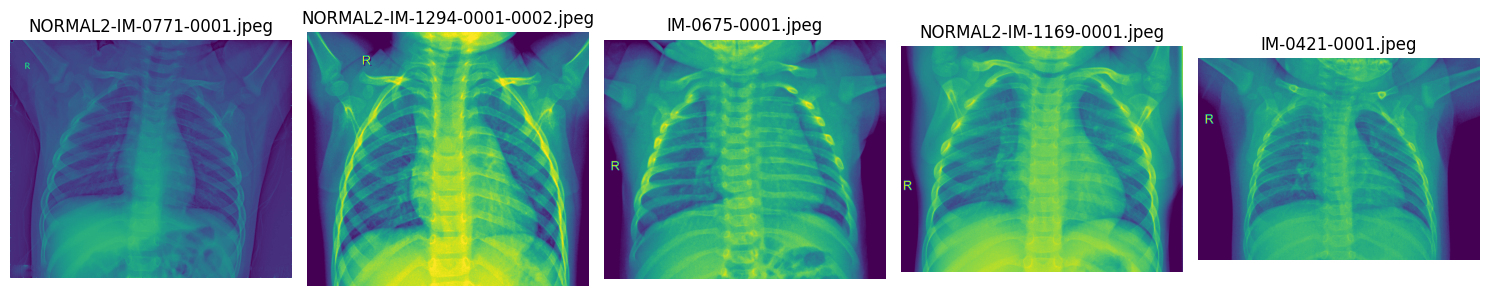

In [13]:
# Specify the path containing the images to visualize
path_to_visualize = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"

# Visualize 10 images from the specified path
visualize_images(path_to_visualize, num_images=5)

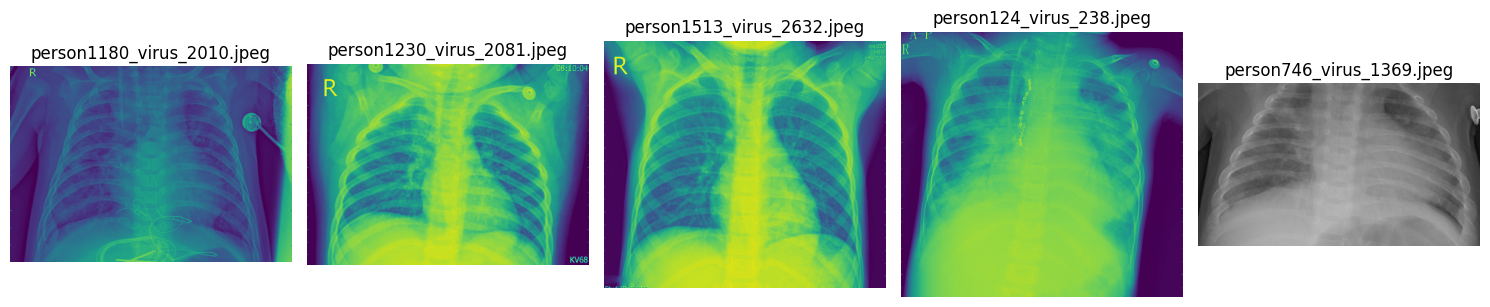

In [14]:
# Specify the path containing the images to visualize
path_to_visualize = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

In [15]:
# Load the Xception base model without the top (classification) layer
base_model = Xception(weights='imagenet',  # Pre-trained weights on ImageNet
                      include_top=False,   # Exclude the top classification layer
                      pooling='avg',       # Pooling strategy for the output
                      input_shape=(256, 256, 3))  # Input shape of images

# Freeze the layers in the base model
base_model.trainable = False

# Build the model
model = Sequential()

# Add the pre-trained Xception base model
model.add(base_model)

# Add a Batch Normalization layer to normalize the activations of the previous layer
model.add(BatchNormalization())

# Add a Dropout layer to prevent overfitting by randomly dropping 45% of the inputs
model.add(Dropout(0.45)) 

# Add a Dense layer with 220 units and ReLU activation function for non-linearity
model.add(Dense(220, activation='relu'))

# Add another Dropout layer to further prevent overfitting by randomly dropping 25% of the inputs
model.add(Dropout(0.25)) 

# Add another Dense layer with 60 units and ReLU activation function for non-linearity
model.add(Dense(60, activation='relu'))

# Add the output layer with 1 unit and sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adamax optimizer and binary crossentropy loss function
model.compile(optimizer=Adamax(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Print model summary to display the architecture and parameter count
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [24]:
# Define early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=5,          # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)  # Restore model weights to the best observed during training

# Fit the model to the training data, with early stopping and validation data
history = model.fit(train_ds,                       # Training data
                    epochs=20,                      # Number of epochs
                    validation_data=validation_ds,  # Validation data
                    callbacks=[early_stopping])    # Early stopping callback

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 163ms/step - accuracy: 0.9728 - loss: 0.0633 - val_accuracy: 0.9770 - val_loss: 0.0637
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - accuracy: 0.9824 - loss: 0.0458 - val_accuracy: 0.9731 - val_loss: 0.0679
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 26s 169ms/step - accuracy: 0.9814 - loss: 0.0531 - val_accuracy: 0.9789 - val_loss: 0.0629
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 26s 174ms/step - accuracy: 0.9827 - loss: 0.0465 - val_accuracy: 0.9789 - val_loss: 0.0590
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 177ms/step - accuracy: 0.9818 - loss: 0.0511 - val_accuracy: 0.9770 - val_loss: 0.0692
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 175ms/step - accuracy: 0.9799 - loss: 0.0476 - val_accuracy: 0.9712 - val_loss: 0.0687
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 174ms/step - accuracy: 0.9860 - loss: 0.0376 - val_accuracy: 0.9731 - val_loss: 0.0795
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 175ms/step - accuracy: 0.9807 - loss: 0

In [25]:
# Evaluate the model on the validation dataset
validation_loss, validation_accuracy = model.evaluate(validation_ds)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9737 - loss: 0.0597
Validation Loss: 0.059971634298563004
Validation Accuracy: 0.9788867831230164


Testing Images:
Found 624 files belonging to 2 classes.
Predictions on Testing Images:
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step


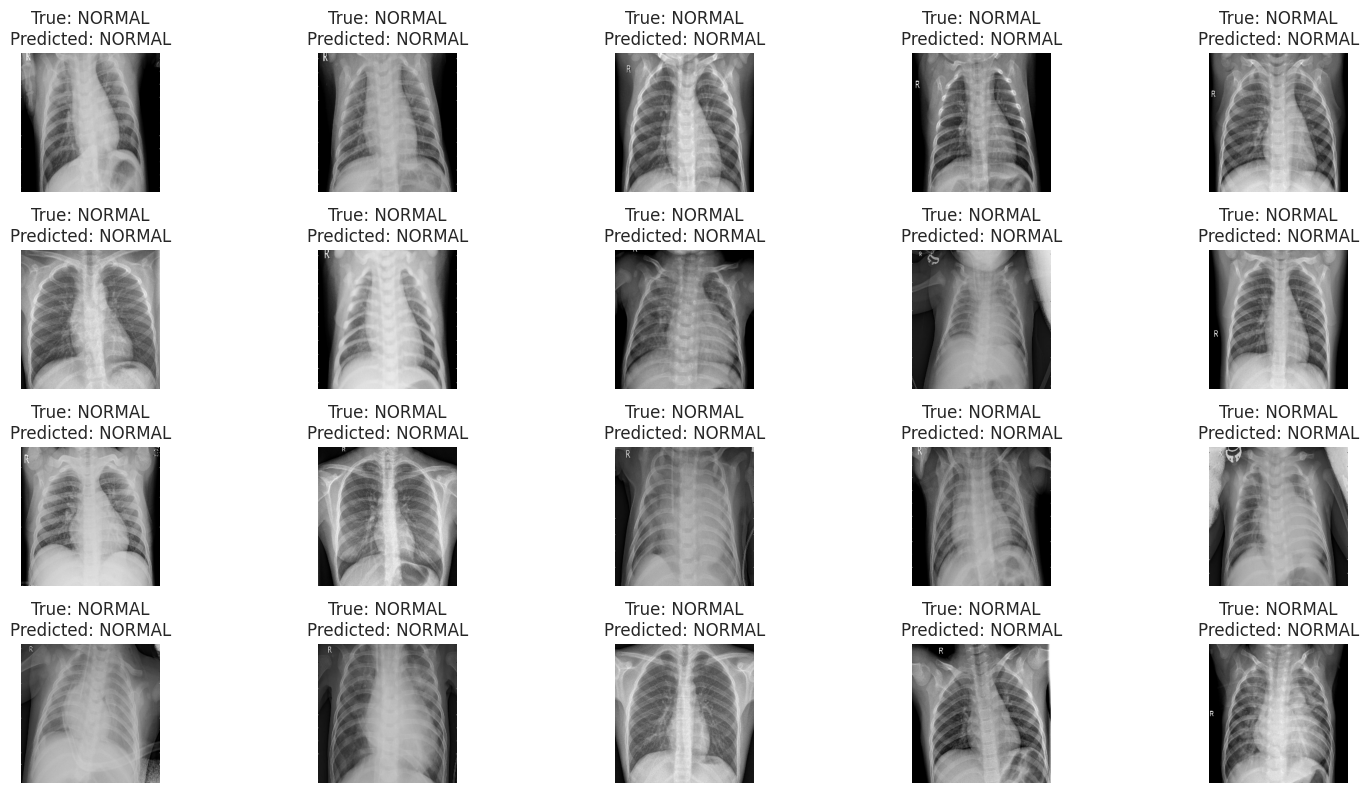

In [29]:
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'
print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32
)

def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    # Generate predictions for a set number of images
    predictions = model.predict(dataset)
    
    # Shuffle the dataset
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))
    
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        # Convert tensor to NumPy array
        images = images.numpy()
        
        # Iterate over each image in the batch
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:  # Check if the total number of images exceeds the desired count
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]
                
                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))  
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on random 20 images from the testing dataset
print('Predictions on Testing Images:')
plot_images_with_predictions(model, test_ds, class_labels, num_images=20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


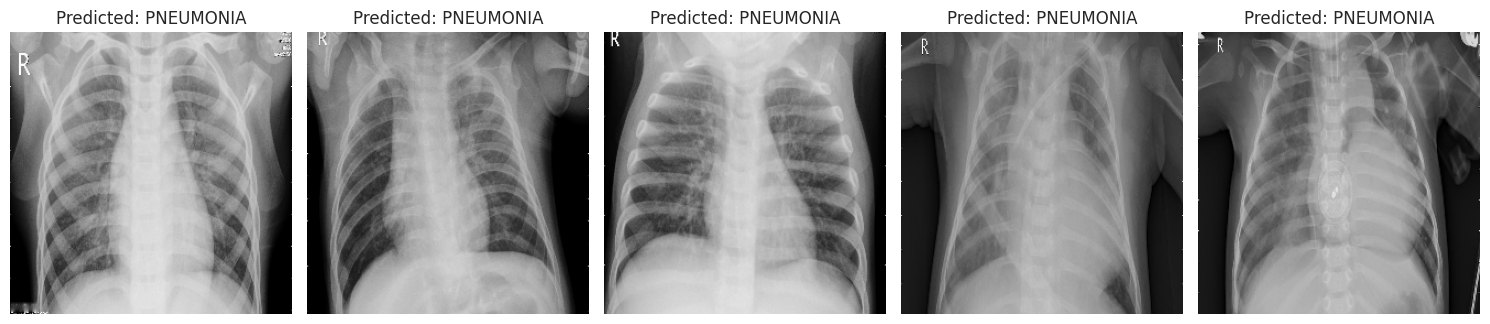

In [30]:
# Path to the directory containing the images
directory_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'

# Select N image files from the directory
image_files = os.listdir(directory_path)[:5]

# Create a figure and axes for subplots
fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

# Load and preprocess each image, make predictions, and display them using a loop
for i, image_file in enumerate(image_files):
    img_path = os.path.join(directory_path, image_file)
    # Load the image using OpenCV
    img = cv2.imread(img_path)
    # Resize the image to (256, 256)
    img = cv2.resize(img, (256, 256)) 

    # Normalize pixel values
    img_array = img.astype(np.float32) / 255.0  

    # Expand the dimensions to match the input shape expected by the model
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)
    actual_prediction = (predictions > 0.5).astype(int)

    # Display the image with predicted label
    # Convert BGR to RGB for displaying with matplotlib
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
    axs[i].axis('off')
    if actual_prediction[0][0] == 0:
        predicted_label = 'Normal'
    else:
        predicted_label = 'PNEUMONIA'
    axs[i].set_title(f'Predicted: {predicted_label}')

# Adjust layout
plt.tight_layout()
plt.show()